In [1]:
import pandas as pd
import json
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import Counter
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Problem 1: Data Preparation

In [3]:
# !pip install apache_beam mwparserfromhell

### 1. Download the Wikipedia text data from Hugging Face, using the 20220301.simple dataset. Extract the first 20,000 articles from the data, store them in a pandas dataframe. Write a function to extract the Hugging Face data into a pandas dataframe.

In [2]:
# from datasets import load_dataset
# simple = load_dataset("wikipedia", "20220301.simple")

In [3]:
from data.loading import load_dataset, load_wikipedia_data
df = load_wikipedia_data("wikipedia", "20220301.simple", None)
print(df.shape)
df.head()

Found cached dataset wikipedia (C:/Users/GIGABYTE/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559)


  0%|          | 0/1 [00:00<?, ?it/s]

(20000, 2)


,text,title
0,April is the fourth month of the year in the J...,April
1,August (Aug.) is the eighth month of the year ...,August
2,Art is a creative activity that expresses imag...,Art
3,A or a is the first letter of the English alph...,A
4,Air refers to the Earth's atmosphere. Air is a...,Air


### Difference between Hard and Soft Lemmatization

In [4]:
from data.processing import Processor, DatasetProcessor

hard = Processor(hard_lemmatize=True)
soft = Processor(hard_lemmatize=False)
n_chars = 100
sample = df.loc[0, 'text'][:n_chars]

h = hard.process(sample)
s = soft.process(sample)

print(f'Original: {sample}')
print(f'Hard normalized: {h}')
print(f'Soft Normalizedl: {s}')

Original: April is the fourth month of the year in the Julian and Gregorian calendars, and comes between March
Hard normalized: ['april', 'be', 'the', 'fourth', 'month', 'of', 'the', 'year', 'in', 'the', 'julian', 'and', 'gregorian', 'calendar', ',', 'and', 'come', 'between', 'march']
Soft Normalizedl: ['april', 'is', 'the', 'fourth', 'month', 'of', 'the', 'year', 'in', 'the', 'julian', 'and', 'gregorian', 'calendar', ',', 'and', 'come', 'between', 'march']


***Notice that am/is/are converted into be (their default verbal form with Hard_Lemmatized)***

In [5]:
dp = DatasetProcessor(df = df.head().copy(), processor_kwargs={'hard_lemmatize':False}, step_by_step= True)
dp()
dp.df

Finished Building DatasetProcessor


,text,title,lowerised,tokenized,lemmatized,stemmed
0,April is the fourth month of the year in the J...,April,"[april, is, the, fourth, month, of, the, year,...","[April, is, the, fourth, month, of, the, year,...","[April, is, the, fourth, month, of, the, year,...","[april, is, the, fourth, month, of, the, year,..."
1,August (Aug.) is the eighth month of the year ...,August,"[august, (, aug., ), is, the, eighth, month, o...","[August, (, Aug., ), is, the, eighth, month, o...","[August, (, Aug., ), is, the, eighth, month, o...","[august, (, aug., ), is, the, eighth, month, o..."
2,Art is a creative activity that expresses imag...,Art,"[art, is, a, creativ, activ, that, express, im...","[Art, is, a, creative, activity, that, express...","[Art, is, a, creative, activity, that, express...","[art, is, a, creativ, activ, that, express, im..."
3,A or a is the first letter of the English alph...,A,"[a, or, a, is, the, first, letter, of, the, en...","[A, or, a, is, the, first, letter, of, the, En...","[A, or, a, is, the, first, letter, of, the, En...","[a, or, a, is, the, first, letter, of, the, en..."
4,Air refers to the Earth's atmosphere. Air is a...,Air,"[air, refer, to, the, earth, 's, atmospher, .,...","[Air, refers, to, the, Earth, 's, atmosphere, ...","[Air, refers, to, the, Earth, 's, atmosphere, ...","[air, refer, to, the, earth, 's, atmospher, .,..."


In [6]:
import time

start = time.perf_counter()
dp = DatasetProcessor(df = df, processor_kwargs={'hard_lemmatize':False}, step_by_step= False)
dp()
end = time.perf_counter()
print(f'Time Taken: {round((end-start)/60, 3)}minutes')
dp.df

Finished Building DatasetProcessor
Time Taken: 4.826minutes


,text,title,lowerised
0,April is the fourth month of the year in the J...,April,"[april, is, the, fourth, month, of, the, year,..."
1,August (Aug.) is the eighth month of the year ...,August,"[august, (, aug., ), is, the, eighth, month, o..."
2,Art is a creative activity that expresses imag...,Art,"[art, is, a, creativ, activ, that, express, im..."
3,A or a is the first letter of the English alph...,A,"[a, or, a, is, the, first, letter, of, the, en..."
4,Air refers to the Earth's atmosphere. Air is a...,Air,"[air, refer, to, the, earth, 's, atmospher, .,..."
...,...,...,...
19995,"Maurice Robert ""Mike"" Gravel (May 13, 1930 – J...",Mike Gravel,"[mauric, robert, ``, mike, '', gravel, (, may,..."
19996,Iva Zanicchi (born 18 January 1940) is an Ital...,Iva Zanicchi,"[iva, zanicchi, (, born, 18, januari, 1940, ),..."
19997,"The North German Confederation (), was first a...",North German Confederation,"[the, north, german, confeder, (, ), ,, wa, fi..."
19998,MiG Alley was a place during the Korean War th...,MiG Alley,"[mig, alley, wa, a, place, dure, the, korean, ..."


In [7]:
dp.df.to_csv('data/normalized_wiki_20k.csv', index=False)

# Problem 2: Word Frequencies and Zipf's Law

### 1. Calculate the frequency of each word in the dataset. Plot the word frequencies against their rank in a log-log scale.
### 2. Fit a line (using any line fitting approach) to the plot that represents Zipf's Law and analyze the results.

In [8]:
df.head(3)

,text,title,lowerised
0,April is the fourth month of the year in the J...,April,"['april', 'is', 'the', 'fourth', 'month', 'of'..."
1,August (Aug.) is the eighth month of the year ...,August,"['august', '(', 'aug.', ')', 'is', 'the', 'eig..."
2,Art is a creative activity that expresses imag...,Art,"['art', 'is', 'a', 'creativ', 'activ', 'that',..."


In [3]:
import pandas as pd
from nltk import Counter

# df = dp.df

df = pd.read_csv('data/normalized_wiki_20k.csv')
df.lowerised = df.lowerised.apply(eval)
word_freq = Counter()
for normalized in df['lowerised']:
    if isinstance(normalized, str):
        normalized = eval(normalized)
    word_freq.update(normalized)
word_freq['the']

455095

In [20]:
# Sort the words by frequency in descending order
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
{i:j for c, (i,j) in enumerate(sorted_words) if c < 10}

{',': 459276,
 'the': 455095,
 '.': 424225,
 'of': 243179,
 'a': 190983,
 'and': 186761,
 'in': 176412,
 ')': 156889,
 '(': 156881,
 'to': 122659}

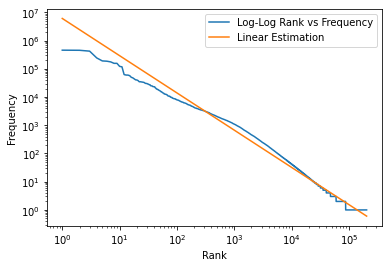

In [21]:
from utils import plot_rank_freqs

plot_rank_freqs(sorted_words)

The graph shows that Zipf's law is true in practice.

# Problem 3: TF-IDF and Document Representation

### 1. Calculate the term frequency (TF) and inverse document frequency (IDF) for each word in the dataset.

In [26]:
from utils import calc_tf_idf
tf_dict, idf_dict, tfidf_dict = calc_tf_idf(df.lowerised, word_freq)

Term - april's tf_score: 208
Term - april's tf_score (log-scale): 3.3180633349627615


100%|████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 33613.55it/s]


Term - april's idf_score (raw): 1498
Term - april's idf_score (log-scale): 1.1255181823005336


In [27]:
tf_dict[0]['april'], idf_dict['april']

(3.3180633349627615, 1.1255181823005336)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

df['normalized'] = df.lowerised.copy()
for i in df.index:
    df.loc[i, 'normalized'] = ' '.join(map(str, df["normalized"][i]))
    
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['normalized'])

In [5]:
tf = np.float16(tfidf_matrix.toarray())

In [6]:
idf = np.float16(tfidf_vectorizer.idf_)

In [7]:
idf.shape, idf.dtype

((162132,), dtype('float16'))

In [8]:
tf.shape, tf.dtype

((20000, 162132), dtype('float16'))

In [9]:
tf_idf = tf * idf.reshape(1, -1)

In [10]:
tf_idf = tf_idf.T   # we need documents (20k) to be columns
print(tf_idf.shape)
tf_idf

(162132, 20000)


array([[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.01078, 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       ...,
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ]],
      dtype=float16)

In [11]:
df["normalized"]

0        april is the fourth month of the year in the j...
1        august ( aug. ) is the eighth month of the yea...
2        art is a creativ activ that express imagin or ...
3        a or a is the first letter of the english alph...
4        air refer to the earth 's atmospher . air is a...
                               ...                        
19995    mauric robert `` mike '' gravel ( may 13 , 193...
19996    iva zanicchi ( born 18 januari 1940 ) is an it...
19997    the north german confeder ( ) , wa first a mil...
19998    mig alley wa a place dure the korean war that ...
19999    verita ' netbackup is a data backup softwar fo...
Name: normalized, Length: 20000, dtype: object

### After calculating the TF-IDF for each document, normalize the document TF-IDF vector. Store the normalized TF-IDF vectors for further use.

In [12]:
from utils import normalize_tfidf

tf_idf_norm = normalize_tfidf(tf_idf)

In [13]:
tf_idf_norm.dtype, tf_idf_norm.shape

(dtype('float16'), (162132, 20000))

### Write a function for normalizing the TF-IDF vectors that can be used for both documents and queries.

In [17]:
tf_idf_norm = tf_idf_norm.T  # reshape for easier search implementation

# Problem 4: Document Search

### 1) Write a function that takes a query as input and performs normalization on the query as you did for the original data. Calculate the TF-IDF representation of the query and normalize it using the function created in Problem 3.

In [18]:
from utils import process_query

### 2) Implement a search function that returns the top-k most relevant documents for the given query using cosine similarity or another similarity measure. Use the precomputed normalized TF-IDF vectors for the documents to calculate the similarities. 

In [19]:
from utils import search

# Problem 5: Evaluation and Reporting

### Evaluate the performance of your search function using example queries and discuss the results.

In [21]:
# Example queries
query1 = "Machine Learning"
# query2 = "Quantum mechanics"
# query3 = "New York City"
# query4 = "Artificial intelligence"
# query5 = "Neural networks"

# Top-k results for each query
k = 5
results1, sim1 = search(query1, k, tf_idf_norm, df)
# results2, sim2 = search(query2, k)
# results3, sim3 = search(query3, k)
# results4, sim4 = search(query4, k)
# results5, sim5 = search(query5, k)

In [22]:
# Print the results
print("Top-{} results for query '{}':".format(k, query1))
print(results1)
print(sim1)
# print("Top-{} results for query '{}':".format(k, query2))
# print(results2)
# print(sim2)
# print("Top-{} results for query '{}':".format(k, query3))
# print(results3)
# print(sim3)
# print("Top-{} results for query '{}':".format(k, query4))
# print(results4)
# print(sim4)
# print("Top-{} results for query '{}':".format(k, query5))
# print(results5)
# print(sim5)

Top-5 results for query 'Machine Learning':
['a student is a person who go to school and is learn someth . student can be child , teenag , or adult who are go to school , but it may also be other peopl who are learn , such a in colleg or univers . a younger student is often call a pupil . usual , student will learn from a teacher or a lectur if at univers . they also do much read . a student can also be a person studi for a specif profess . subject student in school learn subject . there are mani subject in school like : math scienc social studi write read languag relat page educ studi learn peopl', 'bbc learn english is a websit host by the bbc world servic sinc 1996 . it provid free learn materi for peopl who speak english a a second languag and want to improv their english languag skill . refer bbc', 'learn music by ear is learn to play a piec of music by listen to other peopl play it and then tri to play it oneself . in some music tradit there is no written music and everybodi play